# Language Modeling

Group Members:

Vishnu Vikas Devireddi

Rahul Torlapati

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd

from sklearn.metrics import accuracy_score

import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# About the dataset

We took this data from the Hutter Prize datasets, which consists of test data for the Large Text Compression Benchmark. This data is an English Wikipedia dump on Mar, 3 2016.http://download.wikipedia.org/enwiki/20060303/enwiki-20060303-pages-articles.xml.bz2

The size of the data file is approximately 100MB. This is a html file and cleaning of this data is done using the perl code on our system command prompt using the code given on the website.http://mattmahoney.net/dc/textdata.html

And the loaded data contains the text over 100 articles appended in a single line.

In [ ]:
file = open('/content/gdrive/My Drive/Colab Notebooks/text88')
file_data = file.read()
file_words = file_data.split()
file_words = file_words[:100000]

We took only a subset of the data because, our colab was getting crashed on training the LSTM model. This subset of data contains 100,000 words of text.

# Statistical Models

These are the language models that learns the probabilty of word occurence based on the examples of text. 



# Unigram

In a unigram model the probability of each word depends on that word's own probability in the document, so we have one-state finite automata as units. The automaton itself has a probability distribution over the entire vocabulary of the model, summing to 1.

In [ ]:
# Took the count of each word and appended them to a list
wordfreq = []
for w in file_words:
  wordfreq.append(file_words.count(w))

In [ ]:
# creating a dictionary containing the words in the text and their count
uni_dic = dict(zip(file_words, wordfreq))
result = {}
for key, value in uni_dic.items():
  if key not in result.keys():
    result[key] = value
# counting the total number of words
total_count = 0
for key, value in result.items():
  total_count = total_count + value
total_count

100000

In [ ]:
# creating a dictionary containing the probability of each word
uni_dic1 = {}
for key, value in result.items():
  prob = value/total_count
  uni_dic1[key] = prob

-> Entropy is the average negative log2 likelihood per word

-> Coverage : The percentage of known words in the corpus

http://www.phontron.com/slides/nlp-programming-en-01-unigramlm.pdf

In [ ]:
import math
l1 = 0.95
l_unk = float(1-l1)
v = 1000000
w = 0 #word count
h = 0 
unk = 0 #count for unknown words
wd = 'anarchy was once a'
f = wd.split()
re = []
import random
for i in range(20):
  for word in f:
    w = w + 1
    p = l_unk/v
    if word in uni_dic1.keys():
       p = p + l1*uni_dic1[word]
    else:
      unk = unk + 1
  h = h + (-math.log(p,2))
  p1 = p*random.random()*0.01
  res = []
  for key, value in uni_dic1.items():
    if p1 < value:
      res.append(value)
  o = list(set(res))
  o = o[random.randint(0,(len(o)-1))]
  u = list(uni_dic1.keys())[list(uni_dic1.values()).index(o)]
  re.append(str(u))
re = f + re
print(" ".join(word for word in re))
print('entropy=',abs(h/w))
print('coverage=',(w-unk)/w)

anarchy was once a western any act word find philosophy what section use free autism between australia were ideas been means american at term
entropy= 1.4449388117843578
coverage= 1.0


Since the probabilty of the next word depends only on the previous word the generated sentence has no meaning. And it's not even a proper sentence.

# N-Gram

An N-gram model is consists of sequence of n words, that predicts the probabiity of a given n-gram, with any sequence of words in the language.

In this model we took n=3 i.e sequence of three words. 

https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d

In [ ]:
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance  
for w1, w2, w3 in trigrams(file_words, pad_right=True, pad_left=True):
    model[(w1, w2)][w3] += 1
 
# Let's transform the counts to probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [ ]:
import random

# starting words
text = ['anarchism','originated','as','the']
h = 0
 
for i in range(20):
  # select a random probability threshold  
  r = random.random()
  accumulator = .0

  for word in model[tuple(text[-2:])].keys():
      accumulator += model[tuple(text[-2:])][word]
      
      # select words that are above the probability threshold
      if accumulator >= r:
          text.append(word)
          break
  h = h + (-math.log(accumulator,2))

print('entropy=',h) 
print (' '.join([t for t in text]))

entropy= 10.226833182513236
anarchism originated as the legend goes that if the person donating not for their greatness during their last meeting on the defensive lincoln countered


Though the entropy of this model is greater than the unigram, it generated better sentences than the Unigram model. This is due to the creation of N-grams which reduces the subset of words to be chosen for the next word in the generation of a sentence.

# Neural Models

Neural language models use continuous representations or embeddings of words to make their predictions.

Typically, these models are constructed and trained as probabilistic classifiers that learn to predict a probability distribution.

# RNN

I have re-used the code from the lecture for my RNN and the GRU models. Instead of training the data on character by character, I had trained it on words in the data.

In [ ]:
vocab2indx = {}
for word in file_words:
    if word not in vocab2indx:
        vocab2indx[word] = len(vocab2indx)
        
indx2vocab = {}
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(file_words))

Vocab Size:  12563
Total Characters: 100000


In [ ]:
class AutoRegressiveDataset(Dataset):
    """
    """

    def __init__(self, vocab2indx, large_string, MAX_CHUNK=500):
        self.vocab2indx = vocab2indx
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        
        start = idx*self.MAX_CHUNK
        
        #First we build our input values x, which is just each character that 
        #occured in order. We use our vocabular to map the characters to unique
        #IDs for the embedding layer our model will use
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        
        x = [self.vocab2indx[c] for c in sub_string]
        
        #Now we build the target values, in the exact same way as we built our
        #inputs. The differences is that we shift the sub-string over by 1! 
        #This is because we are predicting the _next_ character! 
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        
        y = [self.vocab2indx[c] for c in sub_string]
        
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

In [ ]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, padding_idx=None, layers=1):
        """
        num_embeddings: this is the size of our vocabulary, as each item will require its own embedding. 
        embd_size: how many dimensions to use for the embedding layer
        hidden_size: how many units to use in the RNN layers
        padding_idx: the token used to indicate padding
        layers:  the number of GRU layers to use in the auto-encoder. 
        """
        super(AutoRegressive, self).__init__()
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size, padding_idx=padding_idx)
        self.layers = nn.ModuleList([nn.RNNCell(embd_size, hidden_size)] + 
                                     [nn.RNNCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_embeddings)
        
    
    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)
        
        x = self.embd(input) #(B, T, D)
        
        #grab the device that the model currently resides on
        device = self.embd.weight.device
        
        if self.padding_idx is not None:
            mask = input != self.padding_idx
        else:
            mask = input == input
        mask = mask.to(device)
        #Mask is now (B, T)
        
        #Initial hidden states
        h_prevs = [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]
        
        last_activations = []
        for t in range(T):
            #Grab the mask that tells us which slices in time are currently valid
            #we do the unsqueeze to make it shape (B, 1), so that we can do valid
            #multiplications with the hidden states
            mask_t = mask[:,t].unsqueeze(1) 
            
            x_in = x[:,t,:] #(B, D)
            
            for l in range(len(self.layers)):
                h_prev = h_prevs[l]
                h = self.norms[l](self.layers[l](x_in, h_prev))
                
                h_prevs[l]  = h*mask_t + (~mask_t)*h_prev
                x_in = h
            last_activations.append(x_in)
        
        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)
        
        #Apply linear models to results over time 
        h = self.layernorm(F.leaky_relu(self.linear1(last_activations)))
        h = self.linear2(h) #(B, T, D) -> B(B, T, VocabSize)
        
        return h

In [ ]:
autoRegData = AutoRegressiveDataset(vocab2indx, file_words, MAX_CHUNK=20)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [ ]:
def CrossEntLossTime(x, y):
    """
    x: output predictions with shape (B, T, V)
    y: target labels with shape (B, T)
    
    """
    cel = nn.CrossEntropyLoss()
    
    T = x.size(1)
    
    loss = 0
    
    for t in range(T):
        loss += cel(x[:,t,:], y[:,t])
    
    return loss
    

In [ ]:
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [ ]:
def moveTo(obj, device):
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return x
        


In [ ]:
rnn = train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=10, device=device)

In [ ]:
rnn

,epoch,total time,train loss
0,0,3.037488,802681.729370
1,1,5.633877,719359.768784
2,2,8.231763,717034.152985
3,3,10.860143,711719.932907
4,4,13.459356,701528.532700
5,5,16.053145,688463.273178
6,6,18.647749,674654.468750
7,7,21.248167,659836.690262
8,8,23.839905,644532.036942
9,9,26.428783,630006.485481


In [ ]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 20), dtype=torch.int64, device=device)
seed = 'the problem in anarchy is the'.split()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])
temperature = 5.8
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

In [ ]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print(" ".join(s))

the problem in anarchy is the grand objective focus guest buoys mother kusayla recognition airspeed wood sociocultural fictional superstition jelinek


Due to a large training loss this model wasn't able to generate proper sentences. Though we are generating probabilities to choose from a generated set of words by the model, since some of the words are originated from different language, they may not make sense in another language.

# GRU

In [ ]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, padding_idx=None, layers=1):
        """
        num_embeddings: this is the size of our vocabulary, as each item will require its own embedding. 
        embd_size: how many dimensions to use for the embedding layer
        hidden_size: how many units to use in the RNN layers
        padding_idx: the token used to indicate padding
        layers:  the number of GRU layers to use in the auto-encoder. 
        """
        super(AutoRegressive, self).__init__()
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size, padding_idx=padding_idx)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_embeddings)
        
    
    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)
        
        x = self.embd(input) #(B, T, D)
        
        #grab the device that the model currently resides on
        device = self.embd.weight.device
        
        if self.padding_idx is not None:
            mask = input != self.padding_idx
        else:
            mask = input == input
        mask = mask.to(device)
        #Mask is now (B, T)
        
        #Initial hidden states
        h_prevs = [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]
        
        last_activations = []
        for t in range(T):
            #Grab the mask that tells us which slices in time are currently valid
            #we do the unsqueeze to make it shape (B, 1), so that we can do valid
            #multiplications with the hidden states
            mask_t = mask[:,t].unsqueeze(1) 
            
            x_in = x[:,t,:] #(B, D)
            
            for l in range(len(self.layers)):
                h_prev = h_prevs[l]
                h = self.norms[l](self.layers[l](x_in, h_prev))
                
                h_prevs[l]  = h*mask_t + (~mask_t)*h_prev
                x_in = h
            last_activations.append(x_in)
        
        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)
        
        #Apply linear models to results over time 
        h = self.layernorm(F.leaky_relu(self.linear1(last_activations)))
        h = self.linear2(h) #(B, T, D) -> B(B, T, VocabSize)
        
        return h

In [ ]:
autoRegData = AutoRegressiveDataset(vocab2indx, file_words, MAX_CHUNK=20)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [ ]:
gru = train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=10, device=device)

In [ ]:
gru

,epoch,total time,train loss
0,0,2.600065,799129.823227
1,1,5.182342,719339.150528
2,2,7.781918,717693.874329
3,3,10.361244,716194.703156
4,4,12.950736,712351.663376
5,5,15.544917,703641.807770
6,6,18.147164,691103.803909
7,7,20.737300,676922.646759
8,8,23.323345,661801.332367
9,9,25.919562,645538.634872


In [ ]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 20), dtype=torch.int64, device=device)
seed = 'the problem in anarchy is the'.split()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])
temperature = 5.8
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

In [ ]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print(" ".join(s))

the problem in anarchy is the hopes specialty greenspan goods hafsids heroes spear unlike contains chart elfriede saudi salt located


Even though this model has a large training loss, it has better sentences than the RNN model due to the better generated words.

# Weight-Tied LSTM

This is a pre-trained model of LSTM with an applied RNN dropout parameters customized for language modeling. Here a unit in neural network is temporarily removed from a network.

![alt text](https://miro.medium.com/max/1400/1*D8jriroKkjno8RztHKmMnA.png)

The core concept in RNN dropout is that each hidden unit in a neural network trained with dropout must learn to work with a randomly chosen sample of other units. This makes each hidden unit more robust and drive it towards creating useful features on its own without relying on other hidden units to correct its mistakes.

https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b

Tying weights will reduce the total number of parameters to optimize, thus slimming down the model and reducing complexity and has been shown to reduce perplexity with empirical results.


"Using the Output Embedding to Improve Language Models" (Press & Wolf 2016) https://arxiv.org/abs/1608.05859

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

Hidden activations are multiplied by Bernoulli distributed random variables which take the value 1 with probability p and 0 otherwise.


In [ ]:
def dropout_mask(x, sz, p):
    return x.new(*sz).bernoulli_(1-p).div_(1-p)
  
class RNNDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: 
          return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

Creating a dictionary, sequences of words of length 20 to create the training and testing set of data

In [ ]:
unique_words = sorted(list(set(file_words)))
mapping = dict((c, i) for i,c in enumerate(unique_words))
def generate_seq(x):
  length = 40
  seq = []
  for i in range(length, len(x)):
    s = x[i-length:i]
    seq.append(s)
  return seq

In [ ]:
sequences = generate_seq(file_words)
def encoded_seq(x):
  emt_list = []
  for i in x:
    k = [mapping[word] for word in i]
    emt_list.append(k)
  return emt_list
encoded_sequences = encoded_seq(sequences)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

vocab = len(mapping)

encoded_sequences = np.array(encoded_sequences)

X, Y = encoded_sequences[:,:-20], encoded_sequences[:,-20:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,test_size=0.2, random_state=1)

In [ ]:
train_data = []
test_data = []
for i in range(len(X_train)-1):
    train_data.append([X_train[i],Y_train[i]])
for i in range(len(X_test)-1):
    test_data.append([X_test[i],Y_test[i]])
trainloader = torch.utils.data.DataLoader(train_data)
testloader = torch.utils.data.DataLoader(test_data)

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, hidden_dim, num_layers=1, hidden_dp=0.5, tie_weights=True):
        super(
            LSTM_model, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        
        # Modify the output dimension of the last layer to output embedding_dim
        self.rnns = [nn.LSTM(embedding_dim if l == 0 else hidden_dim, 
                             (hidden_dim if l != num_layers - 1 else embedding_dim) if tie_weights else hidden_dim) for l in range(num_layers)]
        self.rnns = nn.ModuleList(self.rnns)
        
        # Modify the fully-connected layer to take in embedding_dim sized tensors
        self.fc1 = nn.Linear(embedding_dim if tie_weights else hidden_dim, vocab_sz)
        self.hidden_dropout = RNNDropout(hidden_dp)
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        
        # Tie the weights.
        if tie_weights:
            self.fc1.weight = self.embedding.weight
        
    def init_hidden(self, bs):
        # No need to modify this as self.rnns[i].hidden_size will take care of
        # getting the right sizes for us
        weight = next(self.parameters()).data
        return [(weight.new(1, bs, self.rnns[i].hidden_size).zero_(), 
                 weight.new(1, bs, self.rnns[i].hidden_size).zero_()) for i in range(len(self.rnns))]
    
    def forward(self, x):
        bptt_len, bs = x.shape
        vocab_sz = self.embedding.num_embeddings
        
        out = self.embedding(x.to(device))
        hiddens = self.init_hidden(bs)
        for i, rnn in enumerate(self.rnns):   
            out, (hidden, cell) = rnn(out, hiddens[i])
            out = self.hidden_dropout(out)
        
        out = out.flatten(0, 1)
        out = self.fc1(out)
        out = out.view(bptt_len, bs, vocab_sz)
        return out

In [ ]:
model = LSTM_model(len(mapping), embedding_dim=300, hidden_dim=650, 
                            num_layers=2, hidden_dp=0.65, tie_weights=True).to(device)
criterion = CrossEntLossTime
optimizer = optim.Adam(model.parameters(), lr=1e-2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.01, 0.01)
            
model.apply(init_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,399,063 trainable parameters


In [ ]:
epochs = 10
clip = 0.25
train_losses = []
best = np.inf

for e in range(1, epochs + 1):
    model.train()    
    train_loss = 0 
    for inputs, labels in tqdm(trainloader):
        x, y = torch.tensor(inputs), torch.tensor(labels)
        x = x.to(device='cuda')
        y = y.to(device='cuda')
        out = model(x)

        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(trainloader)
    train_losses.append(train_loss)

    
    
    if train_loss < best:
        print("Best model so far. Saving model...")
        best = train_loss
        torch.save({'state_dict': model.state_dict()}, 'wt2.pth')
    
    print("\nEpoch {:3d} | Train Loss {:.4f} ".format(e, train_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.



Best model so far. Saving model...

Epoch   1 | Train Loss 146.7296 



Best model so far. Saving model...

Epoch   2 | Train Loss 146.4984 



Best model so far. Saving model...

Epoch   3 | Train Loss 146.4314 




Epoch   4 | Train Loss 146.5154 




Epoch   5 | Train Loss 146.4510 




Epoch   6 | Train Loss 146.4679 



Best model so far. Saving model...

Epoch   7 | Train Loss 146.4258 




Epoch   8 | Train Loss 146.4272 



Best model so far. Saving model...

Epoch   9 | Train Loss 146.4170 




Epoch  10 | Train Loss 146.4197 


In [ ]:
checkpoint = torch.load('wt2.pth')
model.load_state_dict(checkpoint['state_dict'])

model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, labels in tqdm(testloader):
        x, y = inputs, labels
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        loss = criterion(out,y)

        test_loss += loss.item()
test_loss /= len(testloader)

print("\nTest Loss {:.4f} ".format(test_loss))



Test Loss 146.5158 


In [ ]:
sampling = torch.zeros((1, 20), dtype=torch.int64, device=device)
seed = 'the problem in anarchy is the'.split()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])
temperature = 5.8
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print(" ".join(s))


the problem in anarchy is the institutes fibre exploiters offshore festival became malay energy belgian samaritan metaphysica pathetic theodor permit


This model has a significantly lower training loss compared to the RNN and GRU models. In one way this model has outperformed the neural models in the training phase. But the generated sentences are on par with the GRU model.

This might be due to the generation of the next word using random probabilities that made the GRU and the Weight-tied LSTM to generate these kind of sentences.

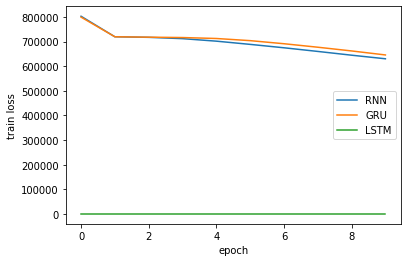

In [ ]:
t = [i for i in range(10)]
sns.lineplot(x='epoch',y='train loss',data=rnn, label='RNN')
sns.lineplot(x='epoch',y='train loss',data=gru, label='GRU')
sns.lineplot(x=t,y=train_losses, label='LSTM')

From the above graph we can see that LSTM performed way better than the GRU and RNN. The loss for LSTM is around 146.40. But due to the large numbers in training losses of RNN and GRU the scalability of this graph is low for LSTM.  

# Conclusion

Considering the Statistical and the Neural models, the N-gram model generated the best output. The Weight-tied LSTM performs equivalently over all epochs and has the least loss. The output generated N-gram model makes the most grammatical sense when compared to all our model. All of the models can be improved to lessen the training loss and imporve accuracy. 